# Install dependencies

In [121]:
!pip install scikit-bio
!pip install face_recognition
!pip install pandas

# Import libs

In [0]:
import os
import math
import pickle

import pandas as pd
import face_recognition
from scipy.spatial import distance_matrix
from skbio.stats.distance import DissimilarityMatrix
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

from google.colab import drive

# Variables

In [0]:
ROOT_FOLDER = "/content/drive"
BASE_FOLDER = f"{ROOT_FOLDER}/My Drive/pycon_worshop/final"
VIDEOS_FOLDER = f"{BASE_FOLDER}/videos"
FRAMES_FOLDER = f"{BASE_FOLDER}/frames"
MODEL_FOLDER = f"{BASE_FOLDER}/model"

# Mount drive folder(s)

In [124]:
drive.mount(ROOT_FOLDER, force_remount=True)

Mounted at /content/drive


# Functions

In [0]:
def resize_image(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

def get_embeddings(path):
  embeddings = None
  try:
    image = cv2.imread(path)
    image = resize_image(image, 600)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # detect the (x, y)-coordinates of the bounding boxes
    # corresponding to each face in the input image
    boxes = face_recognition.face_locations(rgb, model="hog")

    # compute the facial embedding for the face
    embeddings = face_recognition.face_encodings(rgb, boxes)
  except Exception as e:
    print(e)

  return embeddings

def get_people_embeddings(folder_path):
  names = []
  embeddings = []

  for person_name in os.listdir(folder_path):
    person_frames = os.path.join(folder_path, person_name)
    person_embeddings = []
    i = 0

    for frame_name in os.listdir(person_frames):
      frame_path = os.path.join(person_frames, frame_name)
      frame_embeddings = get_embeddings(frame_path)

      if frame_embeddings:
        names.append(f"{person_name}_{i + 1}")
        embeddings.append(frame_embeddings[0])
        i = i + 1
      
  return names, embeddings

# Get embeddings from frames

In [0]:
names, embeddings = get_people_embeddings(FRAMES_FOLDER)

# Save Embeddings

In [0]:
model_path = os.path.join(MODEL_FOLDER, "embeddings.pickle")

with open(model_path, "wb") as f:
  f.write(pickle.dumps([names, embeddings]))

# Embeddings description

In [128]:
ariel = names[0]
print(len(embeddings[0]))
print("-" * 20)
print(embeddings[0])

128
--------------------
[-0.11568833  0.07126477  0.04958219 -0.03700571 -0.09236963  0.01973823
 -0.03737356 -0.06960844  0.16496596 -0.08182656  0.19389865 -0.00301065
 -0.22412783  0.1055381  -0.05782354  0.10394524 -0.17533764 -0.0501297
 -0.10567336 -0.08525231 -0.05479737  0.05490266 -0.01219622  0.00511745
 -0.17416307 -0.28204119 -0.10158107 -0.1132998   0.09437545 -0.04476142
  0.03461063 -0.00478159 -0.10393679 -0.0222072   0.09918912  0.13219036
 -0.037488   -0.00506069  0.19919947  0.01434529 -0.07851326 -0.0266987
  0.06541999  0.27592775  0.07212661  0.07123134  0.14033529 -0.1094289
  0.10522333 -0.22213773  0.05808511  0.08083388  0.10110249  0.12062077
  0.12495771 -0.17105231  0.02717039  0.18409252 -0.13997974  0.15480185
  0.10534046  0.07930472 -0.09727349  0.01564825  0.23687163  0.11463694
 -0.12176163 -0.21409962  0.24057887 -0.17606124 -0.07090242  0.115118
 -0.06647649 -0.1335844  -0.17353225  0.0284452   0.44195032  0.10746357
 -0.11513105 -0.01988591 -0.018

In [129]:
columns = [f"input_{idx}" for idx in range(128)]
df = pd.DataFrame(embeddings, columns=columns, index=names)
df

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11,input_12,input_13,input_14,input_15,input_16,input_17,input_18,input_19,input_20,input_21,input_22,input_23,input_24,input_25,input_26,input_27,input_28,input_29,input_30,input_31,input_32,input_33,input_34,input_35,input_36,input_37,input_38,input_39,...,input_88,input_89,input_90,input_91,input_92,input_93,input_94,input_95,input_96,input_97,input_98,input_99,input_100,input_101,input_102,input_103,input_104,input_105,input_106,input_107,input_108,input_109,input_110,input_111,input_112,input_113,input_114,input_115,input_116,input_117,input_118,input_119,input_120,input_121,input_122,input_123,input_124,input_125,input_126,input_127
ARIEL__CALZADA_1,-0.115688,0.071265,0.049582,-0.037006,-0.092370,0.019738,-0.037374,-0.069608,0.164966,-0.081827,0.193899,-0.003011,-0.224128,0.105538,-0.057824,0.103945,-0.175338,-0.050130,-0.105673,-0.085252,-0.054797,0.054903,-0.012196,0.005117,-0.174163,-0.282041,-0.101581,-0.113300,0.094375,-0.044761,0.034611,-0.004782,-0.103937,-0.022207,0.099189,0.132190,-0.037488,-0.005061,0.199199,0.014345,...,0.238979,0.017558,0.051338,0.144993,0.055193,-0.008827,0.002875,0.054307,-0.119357,0.014028,-0.059950,-0.028592,0.134337,-0.056066,0.062105,0.130226,-0.208206,0.238075,-0.092056,-0.050504,0.051678,0.100374,-0.050646,0.003775,0.261441,-0.287931,0.161781,0.202445,-0.036324,0.036933,-0.025135,0.078533,0.065549,0.092200,-0.215600,-0.128978,-0.089625,-0.147752,-0.076450,-0.001908
ARIEL__CALZADA_2,-0.096916,0.089807,0.079508,-0.008172,-0.060671,0.035139,-0.010056,-0.066420,0.192814,-0.078253,0.224334,0.053177,-0.230897,0.076187,-0.028018,0.111769,-0.140572,-0.059877,-0.125507,-0.037578,-0.053642,0.053548,-0.008865,-0.004342,-0.144522,-0.296778,-0.074911,-0.122341,0.096216,-0.063766,0.002779,0.007118,-0.082440,-0.048642,0.072131,0.104693,0.001895,-0.002390,0.207829,-0.002705,...,0.229290,0.039164,0.057426,0.143152,0.054952,-0.035029,-0.007672,0.095842,-0.126465,0.012387,-0.115866,-0.039969,0.112908,-0.056719,0.062137,0.127911,-0.227114,0.191963,-0.055828,-0.059775,0.072363,0.108317,-0.018092,0.021923,0.250009,-0.270700,0.164279,0.201396,-0.057251,0.051227,-0.038458,0.071474,0.050084,0.058139,-0.213043,-0.118778,-0.092580,-0.145288,-0.034816,0.014115
ARIEL__CALZADA_3,-0.062510,0.030053,0.085277,-0.006117,-0.090228,0.037153,-0.001817,-0.083090,0.139819,-0.146073,0.226256,-0.019485,-0.271337,0.055248,0.011310,0.129191,-0.136273,-0.082117,-0.156731,-0.091078,-0.040248,0.082698,0.015750,0.006459,-0.161420,-0.285443,-0.074355,-0.108913,0.098003,-0.071620,-0.023147,0.006187,-0.092237,-0.053134,0.057776,0.121865,-0.049339,-0.041931,0.211041,0.041228,...,0.243004,-0.015145,0.012096,0.203746,0.093984,0.001914,0.002974,0.026666,-0.129795,-0.030502,-0.109024,-0.077707,0.074707,-0.051837,0.071361,0.085644,-0.191510,0.263965,-0.048619,-0.025534,0.092789,0.133590,-0.068797,0.011834,0.225536,-0.275016,0.123860,0.195440,-0.007470,0.013545,0.002481,0.077733,0.052345,0.086660,-0.213000,-0.142451,-0.061765,-0.125243,0.012675,0.044447
ARIEL__CALZADA_4,-0.121457,0.107222,0.062336,-0.022525,-0.092069,0.029591,-0.048862,-0.093945,0.108825,-0.076024,0.203810,0.015373,-0.279707,0.062537,-0.017416,0.112106,-0.140643,-0.090277,-0.106889,-0.092466,-0.050970,0.042418,-0.000349,0.020353,-0.153271,-0.279627,-0.075480,-0.120016,0.110793,-0.043856,-0.007738,-0.030207,-0.084998,-0.021778,0.089271,0.119232,0.002603,0.015947,0.192650,-0.010221,...,0.222441,0.003148,0.037331,0.153062,0.072501,0.011142,-0.003426,0.101674,-0.130369,-0.017046,-0.106780,-0.059482,0.120368,-0.038731,0.074606,0.140148,-0.238415,0.197044,-0.068649,-0.034141,0.093848,0.126754,-0.034386,0.002765,0.232580,-0.299649,0.195128,0.220768,-0.027137,-0.014409,-0.015149,0.034985,0.060411,0.070657,-0.213947,-0.127492,-0.060413,-0.173671,-0.071662,0.016720
ARIEL__CALZADA_5,-0.086148,0.046722,0.065348,-0.045217,-0.108783,0.040555,-0.035590,-0.074178,0.166224,-0.106193,0.190898,0.04

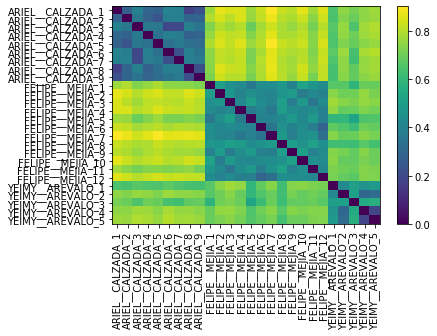

In [130]:
dm = distance_matrix(df.values, df.values)
DissimilarityMatrix(dm, names)

# The training function


In [0]:
names_normalized = ["_".join(name.split("_")[:-1]) for name in names]

In [0]:
le = LabelEncoder()
labels = le.fit_transform(names_normalized)
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(embeddings, labels)

model_path = os.path.join(MODEL_FOLDER, "recognizer.pickle")
with open(model_path, "wb") as f:
  f.write(pickle.dumps(recognizer))

model_path = os.path.join(MODEL_FOLDER, "le.pickle")
with open(model_path, "wb") as f:
  f.write(pickle.dumps(le))